# Fractal Analysis of a Sugnal
The objective of this notebook is to get familiarized with the analysis of the fractal pattern in a given signal. The notebook will explore two different methods
- The DFA method
- The power spectrum analysis method

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Libraries to manage heart beats signals
import wfdb
from wfdb import processing
import heartpy as hp

import sys
sys.path.append('../')
import FractalAnalysis as fa

## Load ECG signal

The ECG of a given subject first needs to be loaded.

The data used is available at this url https://physionet.org/content/autonomic-aging-cardiovascular/1.0.0/

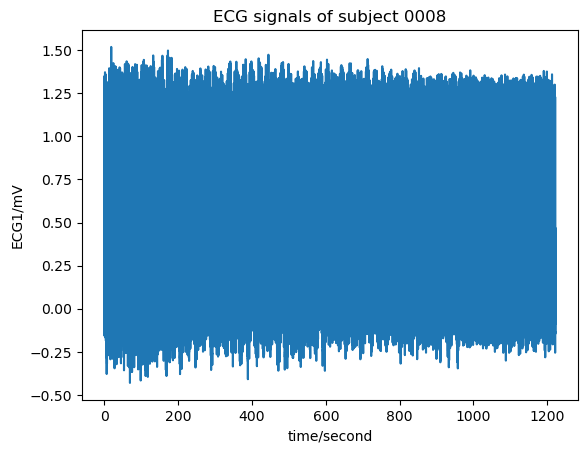

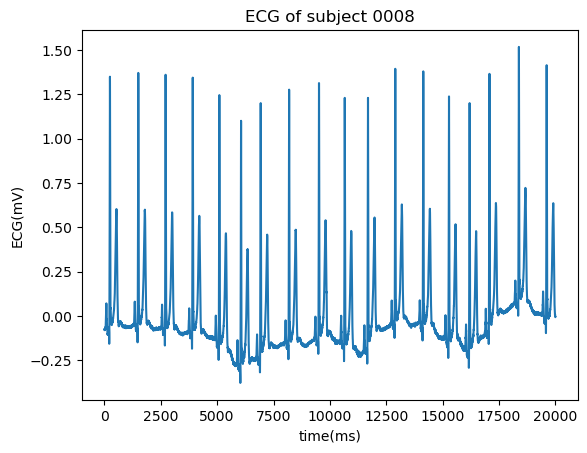

In [3]:
# load a record of a chosen subject
subject = '0008' # Subject number in the interval [0, 1121]
path = '../ECG-data/' + subject
record = wfdb.rdrecord(path, channels = [0])

# plot the record to screen
wfdb.plot_wfdb(record=record, title='ECG signals of subject ' + subject)


# zooming on the signal
signal0 = record.p_signal[:,0]
nb_points = 20000
print_signal0 = signal0[:nb_points]

x = list(range(1, len(print_signal0) + 1))
plt.xlabel('time(ms)')
plt.ylabel('ECG(mV)')
plt.title('ECG of subject ' + subject) #to change

plt.plot(x, print_signal0)
plt.show()

## Converting the ECG into a heart rate signal

The fractal pattern is not observable directly in an ECG signal; however, it can be observed in a heart rate signal. Therefore, a conversion process is necessary to transform the ECG signal into a heart rate signal.

Two different methods will be explored for this conversion. However, the first method is not suitable because when we zoom into the signal, we observe that it remains constant across different intervals, which adversely affects the accuracy of the fractal analysis.


### First method

In [4]:
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):

    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    # Time conversion
    x = list(range(1, len(hrs) + 1))
    x = np.divide(x, 60*1000)
    
    plt.plot(x, hrs)
    plt.xlabel('time(min)')
    plt.ylabel('Heart rate (bpm)')
    plt.title('Heart rate of subject ' + subject)
    plt.show()
    
    return hrs

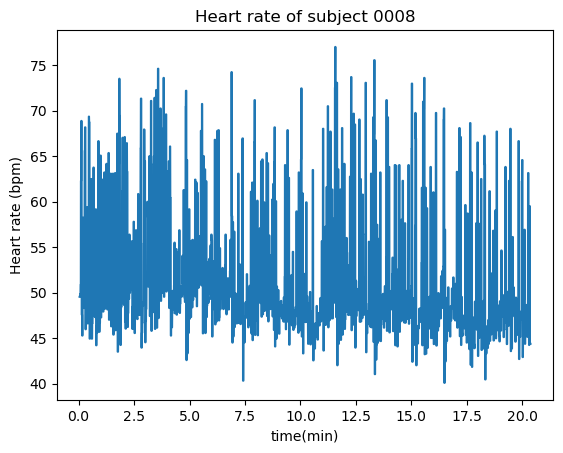

In [5]:
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

heart_rates = peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
                 title="GQRS peak detection on record 100")

heart_rates = heart_rates[~np.isnan(heart_rates)]


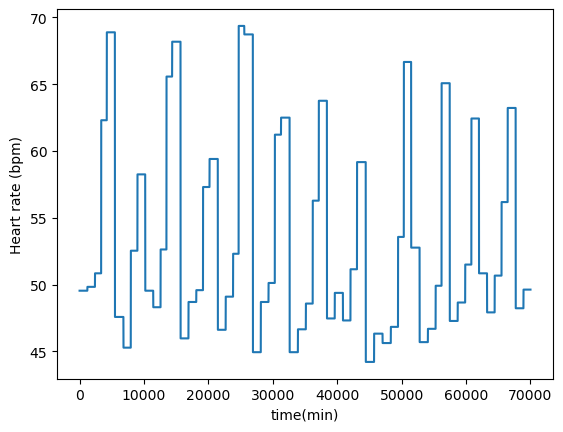

In [6]:
plt.plot(heart_rates[0:70000])
plt.xlabel('time(min)')
plt.ylabel('Heart rate (bpm)')
plt.show()

### Second method

In [7]:
sample_rate = 1000
num_points = 100000

analyse_signal = signal0[0:num_points]
analyse_signal = signal0

# Find the peaks in the ECG signal
try:
    wd, m = hp.process(analyse_signal, sample_rate)
except:
    print("could not :'(")
    
peaks = wd['peaklist']

tmp = np.zeros(len(analyse_signal))

for p in peaks:
    tmp[p] = wd['hr'][p]

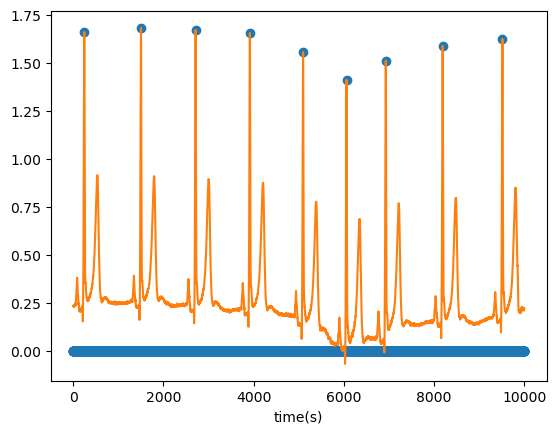

In [8]:
plt.plot(tmp[0:10000], 'o')
plt.plot(wd['hr'][0:10000])
plt.xlabel("time(s)")
plt.show()

c:\Users\ophel\miniconda3\envs\tfe\Lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1200x2000 with 0 Axes>

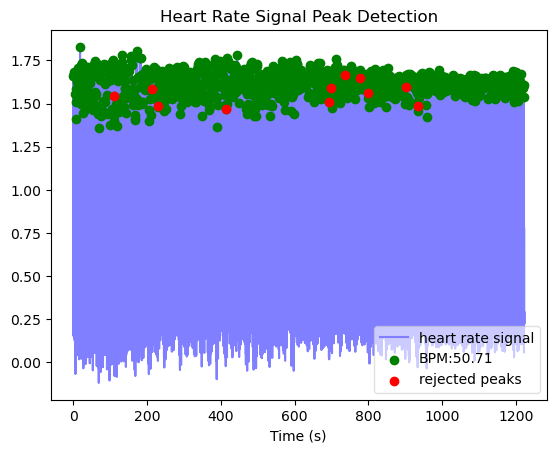

In [9]:
plt.figure(figsize=(12,20))
hp.plotter(wd, m)


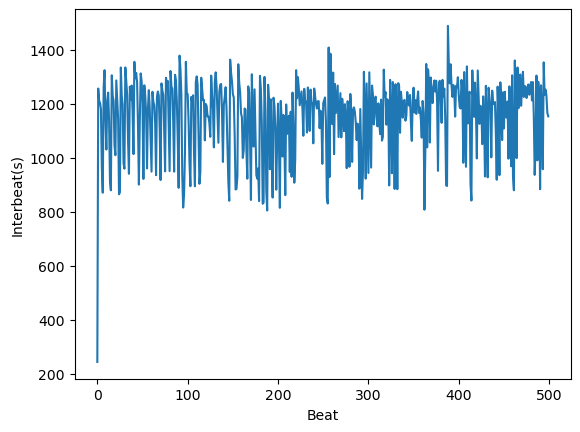

In [10]:
# Generate the heart rate signal
tn = np.zeros(len(peaks)-1)
tn[0] = peaks[0]

for i in range(len(peaks)-2):
    tn[i+1] = peaks[i+1]-peaks[i]
    
plt.plot(tn[0:500])
plt.xlabel("Beat")
plt.ylabel("Interbeat(s)")
plt.show()

In [11]:
#Remove outliers

tn = pd.DataFrame(tn)

Q1 = np.percentile(tn, 25, interpolation= 'midpoint')
Q3 = np.percentile(tn, 75, interpolation= 'midpoint')
IQR = Q3 - Q1

print("Old shape: ", tn.shape)

upper = np.where(tn >= (Q3+1.5*IQR))
lower = np.where(tn <= (Q1-1.5*IQR))

tn.drop(upper[0], inplace = True)
tn.drop(lower[0], inplace = True)

print("New shape: ", tn.shape)



Old shape:  (1035, 1)
New shape:  (1009, 1)


C:\Users\ophel\AppData\Local\Temp\ipykernel_7356\1998121666.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(tn, 25, interpolation= 'midpoint')
C:\Users\ophel\AppData\Local\Temp\ipykernel_7356\1998121666.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(tn, 75, interpolation= 'midpoint')


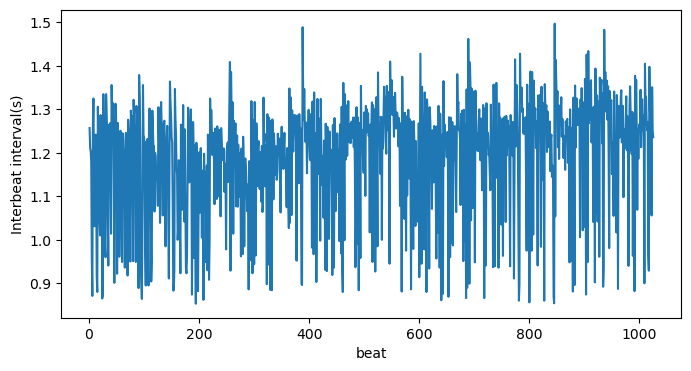

In [12]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(4)

plt.plot(tn[0:1000]*0.001)
plt.xlabel("beat")
plt.ylabel("Interbeat interval(s)")
plt.show()

In [13]:
tn = tn.to_numpy()
tn = [x[0] for x in tn]

## DFA method

In this section, we will use the three distinct implementations of the DFA method.

In [14]:
# Define the scale bounds for the DFA
start = 3
end = len(tn)/8

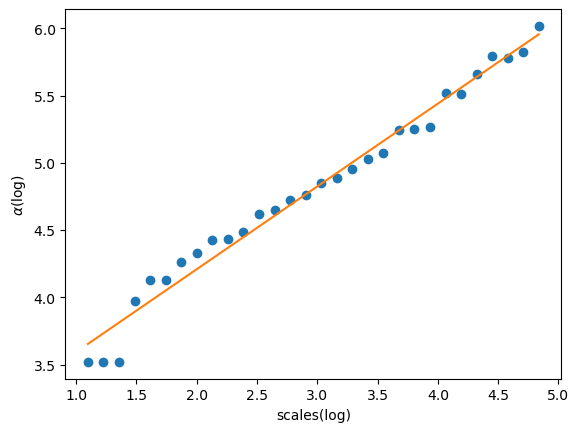

0.6158866952291644

In [15]:
alpha = fa.DFA(tn, limit_start = start, limit_end = end, plot=True)
alpha

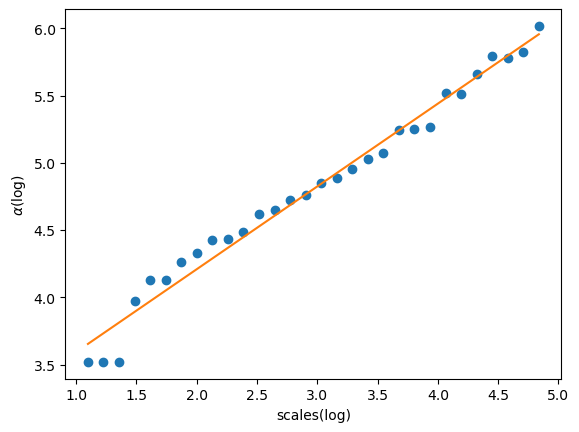

0.6158866952291642

In [16]:
alpha = fa.DFA_fast(tn, limit_start = start, limit_end = end, plot=True)
alpha

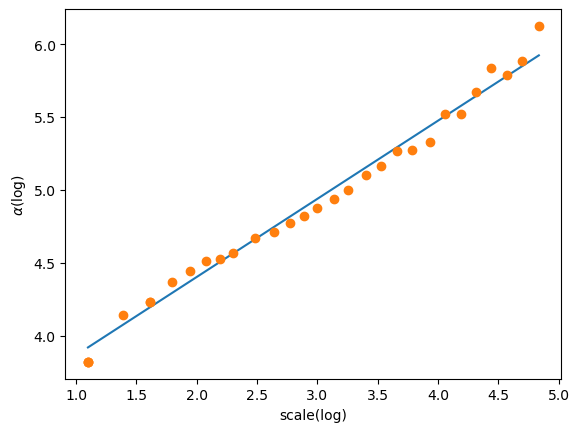

0.535823542397898

In [17]:
x = np.linspace(np.log(start), np.log(end), 30)
lag = np.exp(x).astype(int)

alpha = fa.DFA2(tn, lag, plot=True)
alpha

## Power spectrum analysis

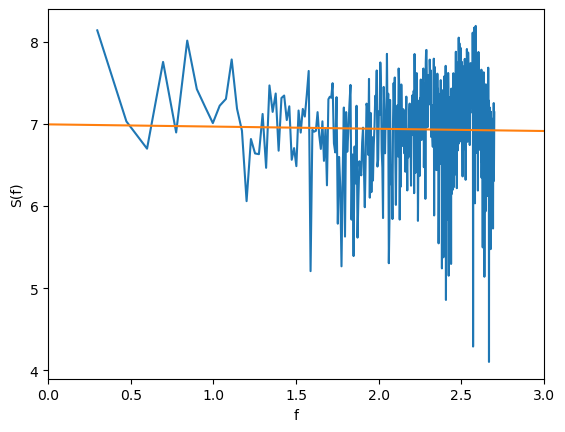

0.02694694776529533

In [18]:
beta = fa.PowerSpectrumAnalysis(tn, plot=True)
beta